In [5]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from data import *

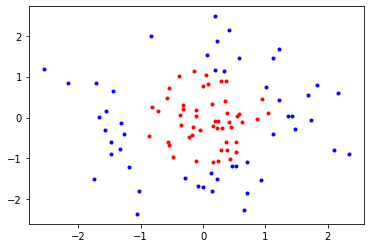

(2, 50)


In [10]:
X = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 100)
# print(np.argpartition(X[:, 0]**2+X[:, 1]**2, 99))
X = X[np.argsort(X[:, 0]**2+X[:, 1]**2), :]
Y = X[50:, :].T
X = X[:50, :].T
Pos = X
Neg = Y

plt.plot(Pos[0,:], Pos[1,:], 'r.')
plt.plot(Neg[0,:], Neg[1,:], 'b.')
plt.show()

print(Pos.shape)

In [19]:
labels = np.concatenate([np.ones(50,), -1*np.ones(50,)])
print(labels.shape)

(100,)


In [17]:
points = np.concatenate([X, Y],axis = 1)
print(points.shape)


(2, 100)


In [30]:
def polynomial_kernel(M):
    return np.array([1, 2**0.5*M[0], 2**0.5*M[1], 2**0.5*np.multiply(M[0],M[1]),M[0]**2, M[1]**2])

points_in_6d = np.apply_along_axis(polynomial_kernel, 0, points)
print(points_in_6d.shape)
print(points_in_6d[:,0])
#for checking
print(2**0.5*points[0,0])



(6, 100)
[ 1.00000000e+00 -1.70004711e-01  4.42587275e-02 -5.32040733e-03
  1.44508009e-02  9.79417482e-04]
-0.1700047113783437


In [41]:

dataset = np.vstack([points_in_6d, labels])
print(dataset.shape)
print(dataset[:,51])

(7, 100)
[ 1.          0.27734742  1.65369927  0.32431398  0.0384608   1.36736063
 -1.        ]


In [60]:
YiXi = np.multiply(points_in_6d,labels.T)
print(YiXi.shape)
print(YiXi[:,51])

(6, 100)
[-1.         -0.27734742 -1.65369927 -0.32431398 -0.0384608  -1.36736063]


In [81]:
D = YiXi.T @YiXi + np.eye(YiXi.shape[1])*1e-5
print(np.all(np.linalg.eigvals(D) >= 0))
lambd = cp.Variable(shape=(100,))
gamma = cp.Variable(shape=(100,))

True


In [82]:
k = 2
C = 0.1
objective = cp.Minimize( -cp.sum(lambd) + 0.5*cp.quad_form(lambd, D) +(lambd[0]+gamma[0])**(k/(k-1))/(k * C)**(k/(k-1)) * (1-1/k))

constraints= [lambd >= 0, lambd.T @ labels == 0, lambd <= C*np.ones(100,), lambd+gamma==C*np.ones(100)]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS, verbose=False)

-2.9586804058730753

In [83]:
print(lambd.value.T @labels)
print(lambd.value[np.where(lambd.value <=0)])

1.1836985776165172e-13
[-8.07398687e-13 -4.64353197e-12 -2.84414633e-12 -1.12241952e-11
 -9.88793565e-12 -6.57482230e-12 -1.51902723e-11 -1.01214622e-11
 -4.37783738e-12 -3.16916027e-12 -1.40746997e-12 -9.33132360e-12
 -1.32826927e-11 -4.79244893e-12 -6.99890843e-12]


In [84]:
j = np.multiply(YiXi, lambd.value.T)
print(j.shape)
w = np.sum(j,axis = 1)
print(w.shape)
print(w)

(6, 100)
(6,)
[ 1.18421014e-13 -6.67078563e-02  2.41911074e-02 -1.24725605e-01
 -1.17369926e+00 -9.02911826e-01]


In [85]:
k = np.where((lambd.value < C) & (lambd.value >= 0.099))
print(k)

(array([27, 28, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       65, 67, 69, 70, 74]),)


In [86]:
b = labels[27] - w.T @ points_in_6d[:,27]
b2 = labels[51] - w.T @ points_in_6d[:,51]
print(b)
print(b2)

1.677127216891585
0.29869418386028856


In [95]:
print(np.where(w.T @ points_in_6d + b >=0))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 54, 56, 57]),)


In [94]:
print(np.where(w.T @ points_in_6d + b <=0))

(array([53, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)


In [100]:
h = 0.02
x_min, x_max = points[0, :].min() - 1, points[0, :].max() + 1
y_min, y_max = points[1, :].min() - 1, points[1, :].max() + 1
print(x_min, x_max)
print(y_min,y_max)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
print(xx.shape)

-3.5453048855905394 3.3301428811146248
-3.3564992763355592 3.4773906383319226
(342, 344)


In [102]:
def polynomial_hyperplane(x,y,w,b):
    m = np.array([1, 2**0.5*x, 2**0.5*y, 2**0.5*x*y ,x**2, y**2])
    return (w.T @ m + b)


In [105]:
Z = np.ones((xx.shape))
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        Z[i][j] = polynomial_hyperplane(xx[i][j],yy[i][j],w,b)

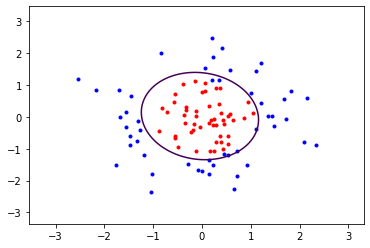

In [109]:
plt.plot(Pos[0,:], Pos[1,:], 'r.')
plt.plot(Neg[0,:], Neg[1,:], 'b.')
plt.contour(xx, yy, Z,[0])
plt.show()